In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [185]:
df = pd.read_csv(
    "ap-northeast-1.csv", 
    names='date arch os region price'.split(),
    parse_dates=[0]
)

In [186]:
df.head()

,date,arch,os,region,price
0,2017-05-08 21:46:36+00:00,c3.8xlarge,Windows,ap-northeast-1a,1.6503
1,2017-05-08 21:46:36+00:00,c3.8xlarge,Windows,ap-northeast-1c,1.7461
2,2017-05-08 21:46:34+00:00,i3.large,SUSE Linux,ap-northeast-1c,0.1223
3,2017-05-08 21:46:34+00:00,i3.large,Linux/UNIX,ap-northeast-1c,0.0223
4,2017-05-08 21:46:17+00:00,c4.8xlarge,SUSE Linux,ap-northeast-1a,0.7890


In [187]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1957000 entries, 0 to 1956999
Data columns (total 5 columns):
 #   Column  Dtype              
---  ------  -----              
 0   date    datetime64[ns, UTC]
 1   arch    object             
 2   os      object             
 3   region  object             
 4   price   float64            
dtypes: datetime64[ns, UTC](1), float64(1), object(3)
memory usage: 74.7+ MB


In [188]:
windows = df.query('os == "Windows" and arch.str.startswith("i")').drop('os', axis=1).copy()

In [189]:
windows.region.value_counts()  # Loks like we have only two regions.

ap-northeast-1c    13462
ap-northeast-1a     9384
Name: region, dtype: int64

In [190]:
region_arch_avg = windows.pivot_table(
    index=['date', 'arch'],
    values='price',
)
region_arch_avg

,,price
date,arch,
2017-03-30 07:36:21+00:00,i2.xlarge,0.2157
2017-03-30 07:45:27+00:00,i2.xlarge,0.2162
2017-03-30 07:46:27+00:00,i2.xlarge,0.2164
2017-03-30 07:47:27+00:00,i2.xlarge,0.2195
2017-03-30 07:48:27+00:00,i2.xlarge,0.2198
...,...,...
2017-05-08 21:37:05+00:00,i3.xlarge,0.2215
2017-05-08 21:38:45+00:00,i3.xlarge,0.2213
2017-05-08 21:39:07+00:00,i3.xlarge,0.2200


In [191]:
# Check if dates are unique within arch group.
arch_groups = region_arch_avg.reset_index().groupby('arch')
np.all(arch_groups.date.value_counts() == 1)

# Looks like they are.

True

In [192]:
# Let's look at dates density and average distance from one point to another.
( 
    pd.DataFrame(
        windows.groupby(['arch', 'region']).date.diff(),
    )
    .set_index([windows.arch, windows.region])
    .groupby(level=[0, 1])
    .agg(['min', 'max', 'count'])
)

date                        
                                          min               max count
arch        region                                                   
i2.2xlarge  ap-northeast-1a -1 days +04:36:18 -1 days +23:59:58  1016
            ap-northeast-1c -1 days +04:36:18 -1 days +23:59:58  1044
i2.4xlarge  ap-northeast-1a -2 days +23:59:33 -1 days +23:59:58   922
            ap-northeast-1c -2 days +23:59:33 -1 days +23:59:59   947
i2.8xlarge  ap-northeast-1a -2 days +23:59:16 -1 days +23:59:58   908
            ap-northeast-1c -2 days +23:59:16 -1 days +23:59:58   921
i2.xlarge   ap-northeast-1a -1 days +14:00:01 -1 days +23:59:59  1491
            ap-northeast-1c -1 days +14:00:01 -1 days +23:59:59  1497
i3.16xlarge ap-northeast-1a -2 days +21:16:54 -1 days +23:59:56   213
            ap-northeast-1c -2 days +21:16:54 -1 days +23:59:56   208
i3.2xlarge  ap-northeast-1a -1 days +11:17:01 -1 days +23:59:59  1244
            ap-northeast-1c -1 days +11:17:01 -1 days +23:59:59  1241
i3.4xlarge  ap-northeast-1a -2 days +23:59:10 -1 days +23:59:59  1059
            ap-northeast-1c -2 days +23:59:10 -1 days +23:59:59  1109
i3.8xlarge  ap-northeast-1a -2 days +23:59:17 -1 days +23:59:59   681
            ap-northeast-1c -2 days +23:59:17 -1 days +23:59:58   616
i3.large    ap-northeast-1a -1 days +08:53:01 -1 days +23:59:58   737
            ap-northeast-1c -1 days +15:24:18 -1 days +23:59:59  4597
i3.xlarge   ap-northeast-1a -1 days +11:50:48 -1 days +23:59:59  1103
            ap-northeast-1c -1 days +11:50:48 -1 days +23:59:58  1272

In [193]:
# Too many changes within one day, guess we can average it by day.
daily_average = (
    windows
    .groupby(['arch', 'region', pd.Grouper(key='date', freq='1D')])
    .mean()
    .reset_index()
)
daily_average

,arch,region,date,price
0,i2.2xlarge,ap-northeast-1a,2017-03-30 00:00:00+00:00,0.448044
1,i2.2xlarge,ap-northeast-1a,2017-03-31 00:00:00+00:00,0.441190
2,i2.2xlarge,ap-northeast-1a,2017-04-01 00:00:00+00:00,0.442645
3,i2.2xlarge,ap-northeast-1a,2017-04-02 00:00:00+00:00,0.449058
4,i2.2xlarge,ap-northeast-1a,2017-04-03 00:00:00+00:00,0.490315
...,...,...,...,...
795,i3.xlarge,ap-northeast-1c,2017-05-04 00:00:00+00:00,0.221109
796,i3.xlarge,ap-northeast-1c,2017-05-05 00:00:00+00:00,0.221265
797,i3.xlarge,ap-northeast-1c,2017-05-06 00:00:00+00:00,0.221164
798,i3.xlarge,ap-northeast-1c,2017-05-07 00:00:00+00:00,0.220622


In [194]:
from itertools import dropwhile, takewhile, chain
from collections import defaultdict


def key_from_arch(a):
    pref, suff = a.split('.')
    inf = int(''.join(takewhile(str.isnumeric, suff)) or 1)
    return pref, inf, ''.join(dropwhile(str.isnumeric, suff))

arch = sorted(
    list(daily_average.arch.unique()),
    key=key_from_arch
)

d = defaultdict(list)
for a in arch:
    p, s = a.split('.')
    d[s].append(a)
    
pairs = list(chain.from_iterable(p for p in d.values() if len(p) == 2))
singles = list(chain.from_iterable(p for p in d.values() if len(p) == 1))
pairs, singles

(['i2.xlarge',
  'i3.xlarge',
  'i2.2xlarge',
  'i3.2xlarge',
  'i2.4xlarge',
  'i3.4xlarge',
  'i2.8xlarge',
  'i3.8xlarge'],
 ['i3.large', 'i3.16xlarge'])

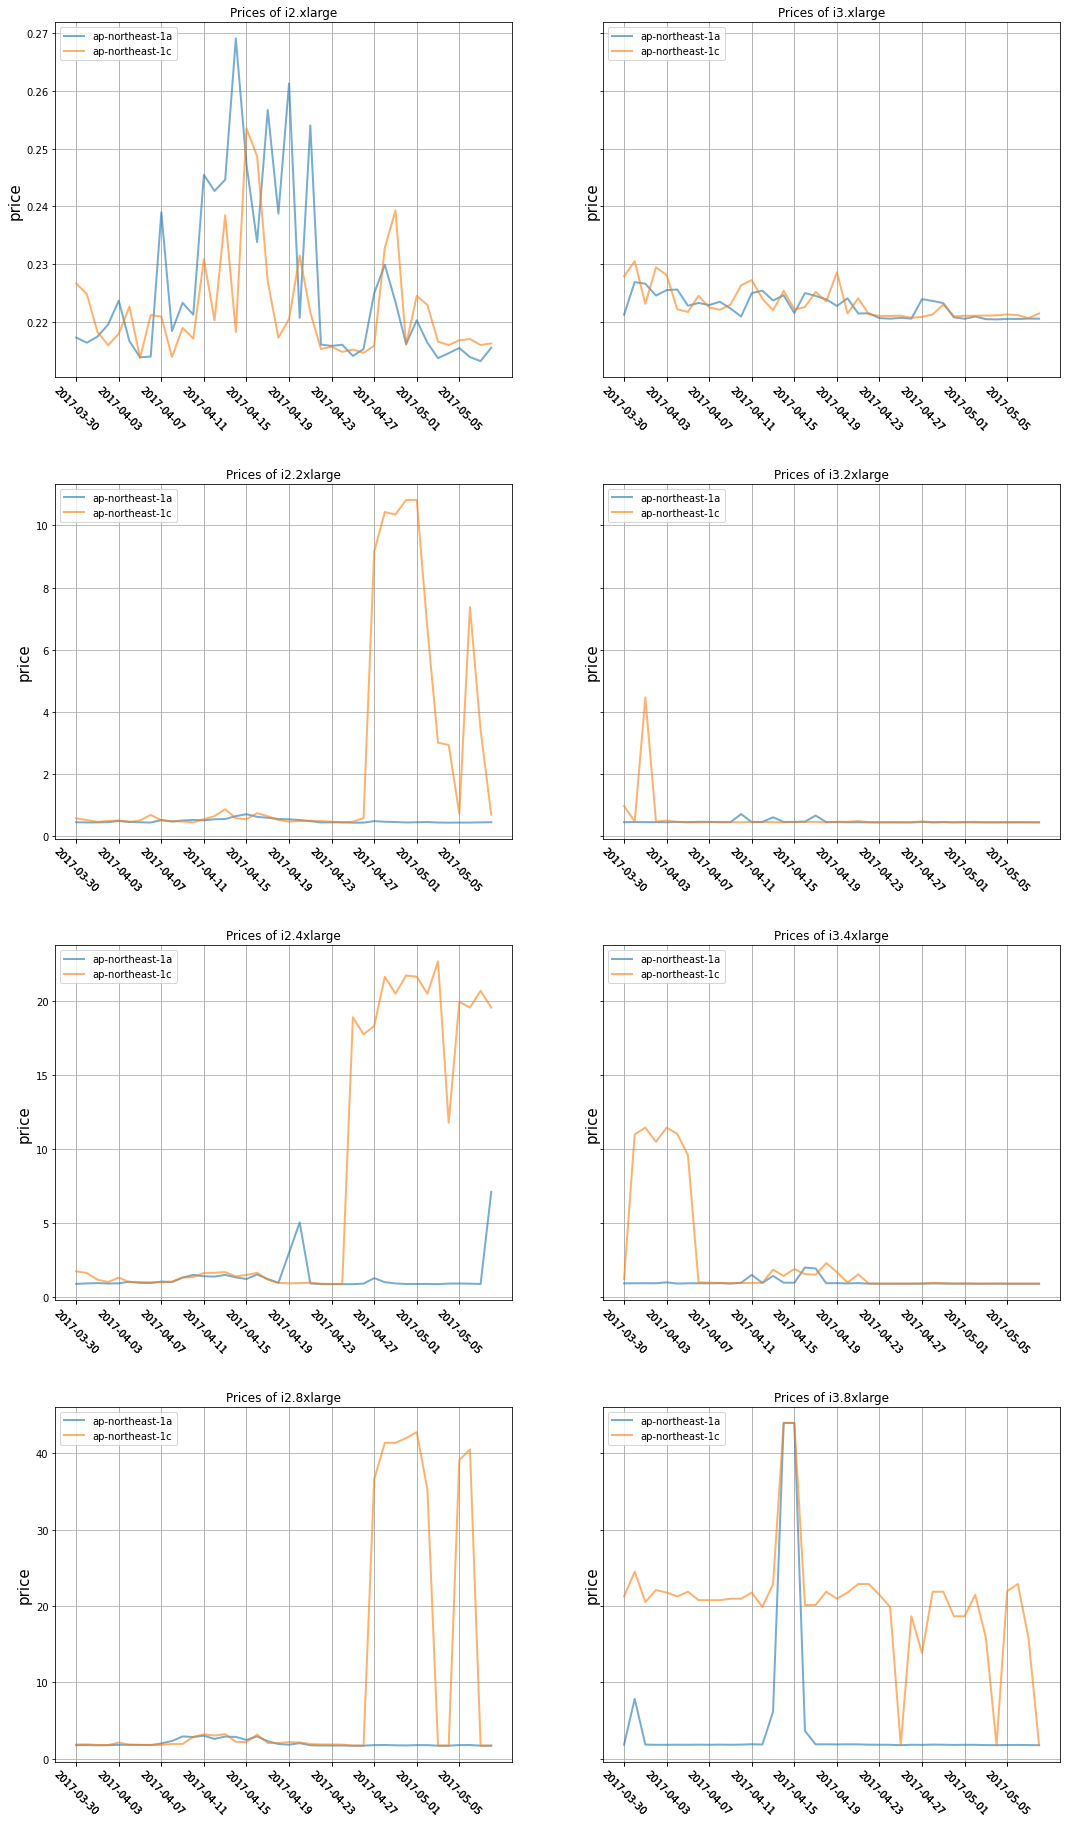

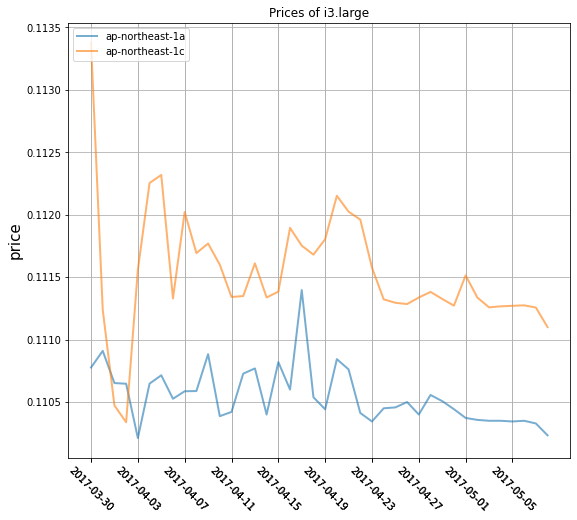

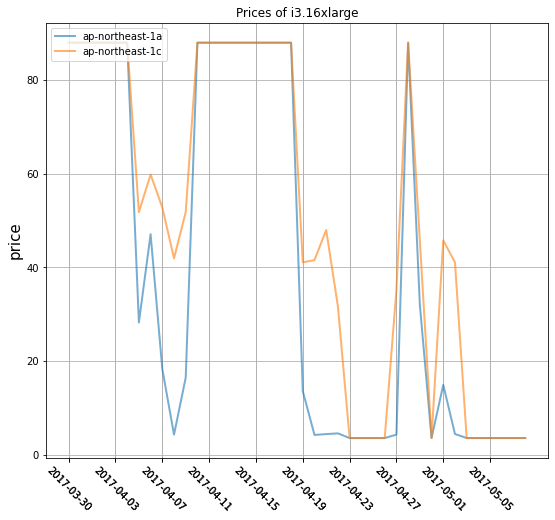

In [195]:
%matplotlib inline

def plot(groups):
#     narch = len(daily_average.arch.unique())
    ngroups = len(groups)
    columns = min(2, len(groups))
    rows = ngroups // columns + ngroups % columns

    label_font = {'size': 15}
    
    # TODO: Should I remove extra axis?
    fig, axs = plt.subplots(
        rows, columns, 
        figsize=(9 * columns, 8 * rows),
        sharey='row'
    )
    axs = np.array([axs]) if not hasattr(axs, 'flat') else axs

    for ax, (name, group) in zip(axs.flat, groups):
        reg1 = group.query('region == "ap-northeast-1a"')
        reg2 = group.query('region == "ap-northeast-1c"')

        lines_reg1, = ax.plot(reg1.date, reg1.price)
        lines_reg2, = ax.plot(reg2.date, reg2.price)
        lines = [lines_reg1, lines_reg2]

        ax.set_title(f'Prices of {name}')
        ax.set_ylabel('price', fontdict=label_font)
        plt.setp(lines, linewidth=2, alpha=0.6)
        ax.legend(
            handles=lines,
            labels=['ap-northeast-1a', 'ap-northeast-1c'], 
            loc='upper left'
        )
        ax.set_xticks(group.date[0:-1:4])
        ax.set_xticklabels(
            group.date[0:-1:4].map(
                lambda x: x.strftime('%Y-%m-%d')
            ), 
            rotation=-45
        )
        ax.grid()

#     plt.setp(axs, xlabel='date', ylabel='price')
    fig.subplots_adjust(hspace=.30)
    
    
groups = daily_average.groupby('arch')
group_of_pairs = [(p, groups.get_group(p)) for p in pairs]
group_of_singles = [(p, groups.get_group(p)) for p in singles]

plot(group_of_pairs)
for group in group_of_singles:
    plot([group])

### Выводы
1. лучше брать тачки в регионе 1a, они там чаше дешевле
1. чем больше ядер тем выше цена :) (привет от Кэпа)
1. кроме размеров x8large цена на i3 меньше и стабильнее (контринтуитивно, если не знать, характеристики размеров, ибо 3 выглядтит круче, чем 2; но очевидно, если посмотреть характеристики i2 и i3 на сайте aws)
1. цены на i2.large, i3.large и i3.16xlarge очень сильно колбасит (интересно из чего складывается цена на тачки в aws?)